In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob

%matplotlib inline

In [2]:
IMG_SIZE = 192

In [3]:
images = np.array([cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)) for i in glob("leedsbutterfly\\images/*")])
masks = np.array([cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)) for i in glob("leedsbutterfly\\segmentations/*")])

In [4]:
images = images / 255
masks = masks / 255

In [5]:
masks_bin = (masks.mean(axis=3).reshape(-1,IMG_SIZE,IMG_SIZE,1) > 0.).astype(np.uint8)

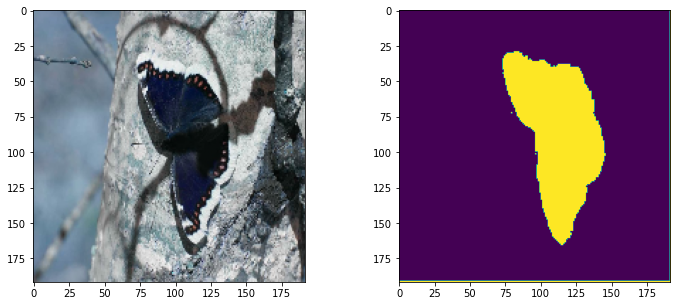

In [6]:
i = np.random.randint(len(images))
img,mask = images[i].copy(),masks_bin[i].copy()

fig,axes = plt.subplots(1,2,figsize=(12,5))
axes[0].imshow(img)
axes[1].imshow(mask.reshape(IMG_SIZE,IMG_SIZE))

In [7]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *

In [41]:
inp = Input(shape=images[0].shape)

conv = Conv2D(32,3,activation="relu",padding="same")(inp)
conv = Conv2D(32,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
block_a = MaxPool2D()(batch)

conv = Conv2D(64,3,activation="relu",padding="same")(block_a)
conv = Conv2D(64,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
block_b = MaxPool2D()(batch)

conv = Conv2D(128,3,activation="relu",padding="same")(block_b)
conv = Conv2D(128,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
block_c = MaxPool2D()(batch)

neck_in = Conv2D(256,1,activation="relu",padding="same")(block_c)
neck = MaxPool2D()(neck_in)
neck_out = Conv2DTranspose(256,1,activation="relu",strides=2,padding="same")(neck)

block_d_in = concatenate([neck_out,block_c])
convt = Conv2DTranspose(128,3,activation="relu",padding="same")(block_d_in)
convt = Conv2DTranspose(128,3,activation="relu",strides=2,padding="same")(convt)
block_d = BatchNormalization()(convt)

block_e_in = concatenate([block_d,block_b])
convt = Conv2DTranspose(64,3,activation="relu",padding="same")(block_e_in)
convt = Conv2DTranspose(64,3,activation="relu",strides=2,padding="same")(convt)
block_e = BatchNormalization()(convt)

block_f_in = concatenate([block_e,block_a])
convt = Conv2DTranspose(32,3,activation="relu",strides=2,padding="same")(block_f_in)
convt = Conv2DTranspose(32,3,activation="relu",padding="same")(convt)
block_f = BatchNormalization()(convt)

convt = Conv2DTranspose(3,3,activation="relu",strides=2,padding="same")(block_f)
out = Conv2D(1,1,strides=2,padding="same",activation="sigmoid")(convt)

model = keras.Model(inp,out,name="unet")

In [42]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 192, 192, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 192, 192, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 192, 192, 32) 128         conv2d_25[0][0]                  
_______________________________________________________________________________________________

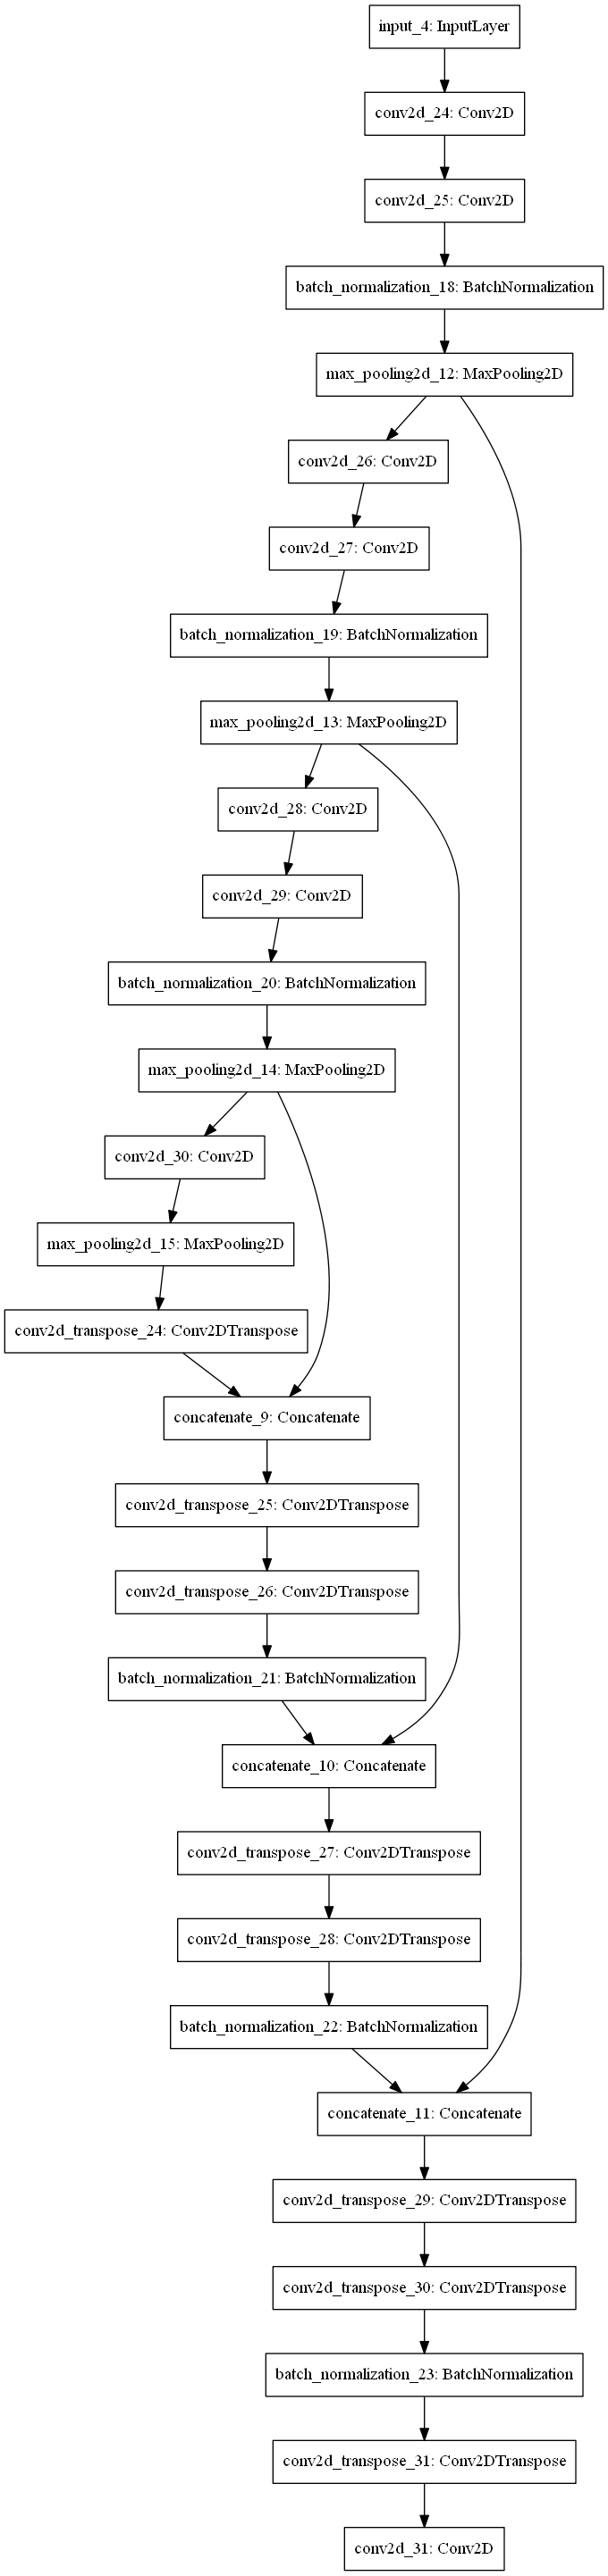

In [43]:
keras.utils.plot_model(model,to_file="doc/unet.png")

In [44]:
index =  np.arange(0,len(images))
np.random.shuffle(index)

X,Y = images[index],masks_bin[index]

In [45]:
model.compile(optimizer="adam",loss="binary_crossentropy")

In [46]:
grid = [
    [8,10],
    [4,10],
    [2,15],
    [1,15]
]

In [47]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/unet",
        save_weights_only=True,
        monitor='loss',
        save_best_only=True,
    )

In [48]:
class SaveEpoch(keras.callbacks.Callback):
    def __init__(self,base):
        self.base = base
        
    def on_epoch_end(self,epoch,log, **kwargs):
        fig,axes = plt.subplots(1,3,figsize=(15,6))
        fig.suptitle(f"Epoch : {self.base + epoch} | Loss : {log['loss']}")
        img = images[0:1].copy()
        mask = masks_bin[0].copy()
        pred = self.model.predict(img)
        
        axes[0].imshow(img[0])
        axes[0].axis("off")
        axes[0].set_title("Image")
        
        axes[1].imshow(mask.reshape(IMG_SIZE,IMG_SIZE),cmap="gray")
        axes[1].axis("off")
        axes[1].set_title("Ground Truth")
        
        axes[2].imshow(pred.reshape(IMG_SIZE,IMG_SIZE),cmap="gray")
        axes[2].axis("off")
        axes[2].set_title("Predicted Mask")
        
        fig.savefig(f"doc/epochs_gif/unet/{self.base + epoch}.jpg")
        plt.close();

In [49]:
alpha_c = np.ones((IMG_SIZE,IMG_SIZE,3)) * np.array([1,0,0])

In [50]:
hist = []
saveepoch = SaveEpoch(0)

for batch_size,epochs in grid:
    history = model.fit(X,Y,batch_size=batch_size,epochs=epochs,callbacks=[model_checkpoint,saveepoch])
    hist.append(history)
    saveepoch.base += epochs

Train on 832 samples
Epoch 1/10
832/832 [==============================] - 12s 14ms/sample - loss: 0.3443
Epoch 2/10
832/832 [==============================] - 11s 13ms/sample - loss: 0.2643
Epoch 3/10
832/832 [==============================] - 11s 13ms/sample - loss: 0.2387
Epoch 4/10
832/832 [==============================] - 12s 15ms/sample - loss: 0.2136
Epoch 5/10
832/832 [==============================] - 14s 17ms/sample - loss: 0.2051
Epoch 6/10
832/832 [==============================] - 16s 20ms/sample - loss: 0.1750
Epoch 7/10
832/832 [==============================] - 20s 24ms/sample - loss: 0.1579
Epoch 8/10
832/832 [==============================] - 21s 25ms/sample - loss: 0.1437
Epoch 9/10
832/832 [==============================] - 23s 27ms/sample - loss: 0.1300
Epoch 10/10
832/832 [==============================] - 21s 26ms/sample - loss: 0.1070
Train on 832 samples
Epoch 1/10
832/832 [==============================] - 26s 31ms/sample - loss: 0.1436
Epoch 2/10
832/832 [==

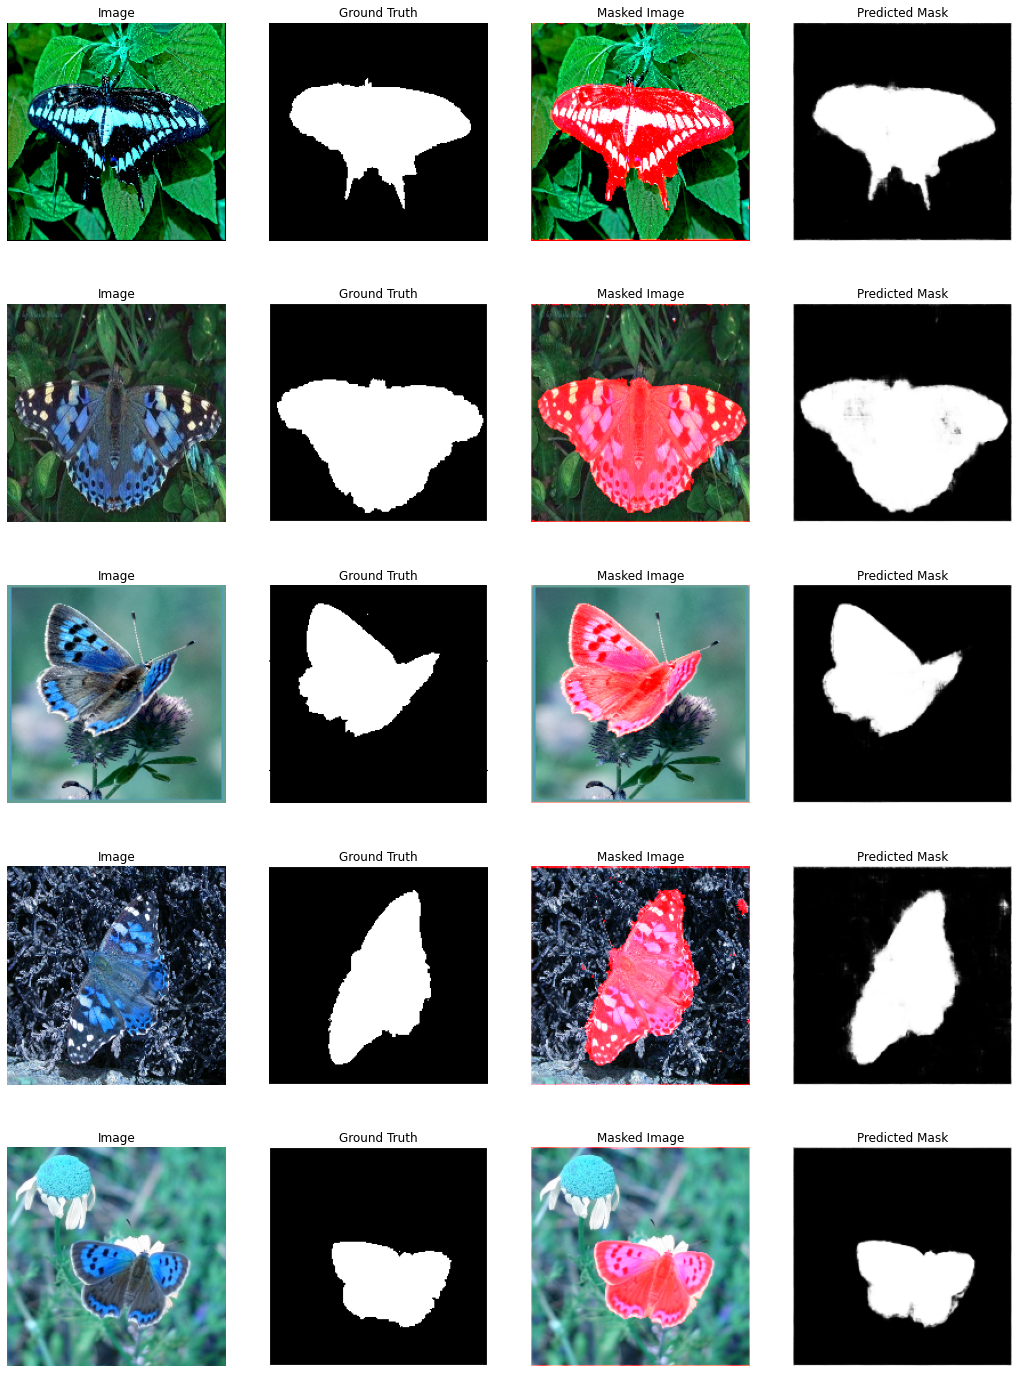

In [51]:
ind = np.random.randint(len(images),size=(5,))

fig,axes = plt.subplots(5,4,figsize=(18,25))

for i,(a0,a1,a2,a3) in zip(ind,axes):
    img,mask = images[i].copy(),masks_bin[i].copy()
    pred = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3)).reshape(IMG_SIZE,IMG_SIZE)
        
    masked = img.copy()
    box = masked[pred > 0.1].copy()
    box[:,0] = 1
    masked[pred > 0.1] = box
    
    a0.imshow(img)
    a0.set_title("Image")
    a0.axis("off")

    a1.imshow(mask.reshape(IMG_SIZE,IMG_SIZE),cmap="gray")
    a1.set_title("Ground Truth")
    a1.axis("off")

    
    a2.imshow(masked)
    a2.set_title("Masked Image")
    a2.axis("off")
     
    a3.imshow(pred,cmap="gray")
    a3.set_title("Predicted Mask")
    a3.axis("off")

In [56]:
fig.savefig("doc/unet_output.png")

In [53]:
import pandas as pd

In [54]:
h0,h1,h2,h3 = hist

h0 = pd.DataFrame(h0.history)
h1 = pd.DataFrame(h1.history)
h2 = pd.DataFrame(h2.history)
h3 = pd.DataFrame(h3.history)

h0['batch_size'] = 8
h1['batch_size'] = 4
h2['batch_size'] = 2
h3['batch_size'] = 1

history = [h0,h1,h2,h3]

# history = pd.concat(history)
# history.to_csv("checkpoints/conv_enc_hist.csv")

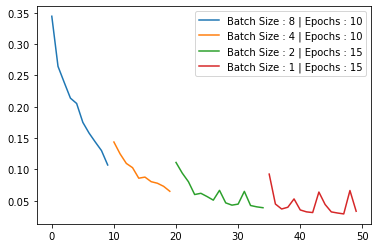

In [55]:
base = 0

for h,(b,e) in zip(history,grid):
    plt.plot(h.index + base,h.loss, label=f"Batch Size : {b} | Epochs : {e}")
    base += e
    
plt.legend()